In [7]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sc= SparkContext()
sqlContext = SQLContext(sc)

## (Down)Load the database
[Kagle USA Housing](https://www.kaggle.com/aariyan101/usa-housingcsv)
0. Avg. Area Income
1. Avg. Area House Age
2. Avg. Area Number of Rooms
3. Avg. Area Number of Bedrooms
4. Area Population
5. Price
6. Address

Target = Price

In [ ]:
import functools
pdf = pd.read_csv('USA_Housing.csv')
pdf = pdf.drop(columns=['Address'])
data = sqlContext.createDataFrame(pdf)

## Data exploration

In [86]:
data.show(3)

+------------------+-------------------+-------------------------+----------------------------+------------------+------------------+
|  Avg. Area Income|Avg. Area House Age|Avg. Area Number of Rooms|Avg. Area Number of Bedrooms|   Area Population|             Price|
+------------------+-------------------+-------------------------+----------------------------+------------------+------------------+
| 79545.45857431678|  5.682861321615587|        7.009188142792237|                        4.09|23086.800502686456|1059033.5578701235|
| 79248.64245482568| 6.0028998082752425|        6.730821019094919|                        3.09| 40173.07217364482|  1505890.91484695|
|61287.067178656784|  5.865889840310001|        8.512727430375099|                        5.13| 36882.15939970458|1058987.9878760849|
+------------------+-------------------+-------------------------+----------------------------+------------------+------------------+
only showing top 3 rows



As the columns names have spaces, let's rename them.

In [88]:
oldColumns = data.schema.names
newColumns = ["Income", "Age", "Rooms", "Bedrooms", "Population", "Price"]

data = functools.reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), data)

data.printSchema()

root
 |-- Income: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Rooms: double (nullable = true)
 |-- Bedrooms: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Price: double (nullable = true)



In [89]:
data.show(3)

+------------------+------------------+-----------------+--------+------------------+------------------+
|            Income|               Age|            Rooms|Bedrooms|        Population|             Price|
+------------------+------------------+-----------------+--------+------------------+------------------+
| 79545.45857431678| 5.682861321615587|7.009188142792237|    4.09|23086.800502686456|1059033.5578701235|
| 79248.64245482568|6.0028998082752425|6.730821019094919|    3.09| 40173.07217364482|  1505890.91484695|
|61287.067178656784| 5.865889840310001|8.512727430375099|    5.13| 36882.15939970458|1058987.9878760849|
+------------------+------------------+-----------------+--------+------------------+------------------+
only showing top 3 rows



### Visualizing some relationships and the correlation between all variables

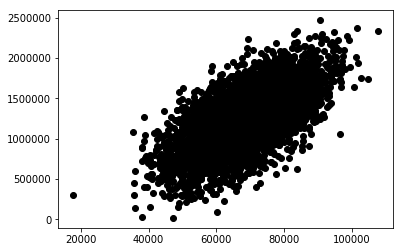

In [131]:
import matplotlib.pyplot as plt

X = pdf['Avg. Area Income']
y = pdf.Price
plt.scatter(X, y,  color='black')

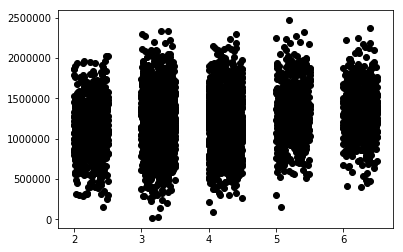

In [132]:
import matplotlib.pyplot as plt

X = pdf['Avg. Area Number of Bedrooms']
y = pdf.Price
plt.scatter(X, y,  color='black')

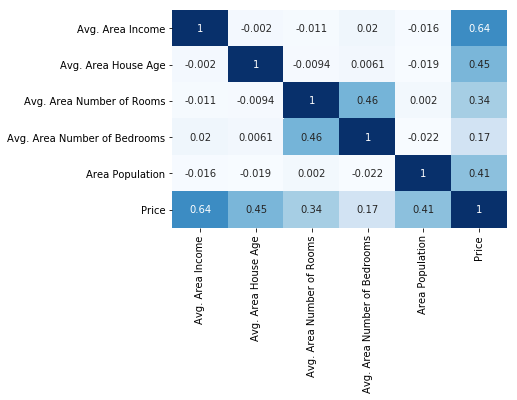

In [91]:
sns.heatmap(pdf.corr(), cbar=False, annot=True, cmap="Blues")

In [92]:
house_desc = pdf.describe()
house_desc.transpose()

,count,mean,std,min,25%,50%,75%,max
Avg. Area Income,5000.0,6.858311e+04,10657.991214,17796.631190,61480.562388,6.880429e+04,7.578334e+04,1.077017e+05
Avg. Area House Age,5000.0,5.977222e+00,0.991456,2.644304,5.322283,5.970429e+00,6.650808e+00,9.519088e+00
Avg. Area Number of Rooms,5000.0,6.987792e+00,1.005833,3.236194,6.299250,7.002902e+00,7.665871e+00,1.075959e+01
Avg. Area Number of Bedrooms,5000.0,3.981330e+00,1.234137,2.000000,3.140000,4.050000e+00,4.490000e+00,6.500000e+00
Area Population,5000.0,3.616352e+04,9925.650114,172.610686,29403.928702,3.619941e+04,4.286129e+04,6.962171e+04
Price,5000.0,1.232073e+06,353117.626581,15938.657923,997577.135049,1.232669e+06,1.471210e+06,2.469066e+06


## Create a new data frame in the format the model requires
Let's try using all features to predic the value of Price.

In [118]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['Income', "Age", "Rooms", "Bedrooms", "Population", "Price"], outputCol = 'features')
vData = vectorAssembler.transform(data)
vData = vData.select(['features', 'Price'])
vData.show(3)


+--------------------+------------------+
|            features|             Price|
+--------------------+------------------+
|[79545.4585743167...|1059033.5578701235|
|[79248.6424548256...|  1505890.91484695|
|[61287.0671786567...|1058987.9878760849|
+--------------------+------------------+
only showing top 3 rows



### Split the data
It is necessary to split the data in 2 sets, the first for trainning and the second for tests. We'll use 70% of data for training and 30% for tests.

In [133]:
splits = vData.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1]

## Creates the model and fits it

Get trainning outputs, errors and then predict test values.

In [120]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='Price', maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train)
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: [5.808479359873488,44343.99857267503,37460.88534468191,-2861.835549126214,4.1048777606885745,0.7649828434070027]
Intercept: -772752.5737059148


In [121]:
trainingSummary = model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 27014.866437
r2: 0.994202


In [122]:
train.describe().show()

+-------+------------------+
|summary|             Price|
+-------+------------------+
|  count|              3527|
|   mean|1230507.0335000402|
| stddev|  354818.900160898|
|    min|31140.517620186045|
|    max|2469065.5941747027|
+-------+------------------+



In [123]:
predictions = model.transform(test)
predictions.select("prediction","Price","features").show(5)

+-----------------+------------------+--------------------+
|       prediction|             Price|            features|
+-----------------+------------------+--------------------+
|535490.1012045156| 599504.0192866956|[36100.4442266807...|
|133411.0331194012|152071.87474956046|[40366.6162912572...|
|804351.3360516398| 798639.6541779223|[40503.5413321989...|
|461132.4313693949| 513215.9882314093|[42822.3110961679...|
|464088.5852815466|503065.50562420936|[44247.1490373890...|
+-----------------+------------------+--------------------+
only showing top 5 rows



### Evaluating the error on predicted values

In [126]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Price",metricName="r2")
print("R Squared (R2) on test data = %g" % evaluator.evaluate(predictions))
print("Variance score: 1 is perfect prediction")

R Squared (R2) on test data = 0.993628
Variance score: 1 is perfect prediction


### Dislays how far is our prediction from test values

A diagonal line is the perfect predictor.

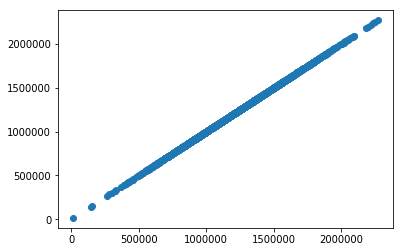

In [125]:
plt.scatter(test.select(['Price']).collect(), predictions.select(['Price']).collect())